In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [71]:
np.random.seed(42)
datasets = f'../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes_spectra_kde/', exist_ok=True)

['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [72]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


# simulation

In [73]:
# Good connectomes Previously fitted and had nice results
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]

connectome_file = 'rhesus_brain_2.graphml'
# connectome_file = 'p.pacificus_neural.synaptic_2.graphml'
# connectome_file = 'mouse_visual.cortex_2.graphml'
# connectome_file = 'mouse_brain_1.graphml'
# connectome_file = 'c.elegans_neural.male_1.graphml'

warm_up = n_iteration = 5000


real_graph = nx.read_graphml(datasets + connectome_file)
real_graph = nx.to_numpy_array(real_graph)
print(f'Nodes: {real_graph.shape[0]} | {connectome_file}')



Nodes: 91 | rhesus_brain_2.graphml


In [74]:
def find_optimal_d(real_graph, d_values, warm_up=1000, n_iteration=1000, patience=50, dist_type='KL'):
    best_gic = float('inf')
    optimal_d = None
    results_dict = {}
    
    print("Starting d optimization...")
    for d in d_values:
        print(f"\nTesting d = {d}")
        try:
            # Get logit graph and GIC for current d
            logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, _ = get_logit_graph(
                real_graph=real_graph,
                d=d,
                warm_up=warm_up,
                n_iteration=n_iteration,
                patience=patience,
                dist_type=dist_type
            )
            
            current_gic = gic_values[0]
            
            results_dict[d] = {
                'gic': current_gic,
                'sigma': sigma,
                'best_iteration': best_iteration,
                'logit_graph': logit_graph
            }
            print(f"d = {d}: GIC = {current_gic:.4f}")
            
            # Update best if current is better
            if current_gic < best_gic:
                best_gic = current_gic
                optimal_d = d
                print(f"New best d found: {d} (GIC: {current_gic:.4f})")
                
        except Exception as e:
            print(f"Error occurred for d = {d}: {str(e)}")
            results_dict[d] = {
                'error': str(e)
            }
            continue
    
    print("\nOptimization complete!")
    print(f"Optimal d: {optimal_d}")
    print(f"Best GIC: {best_gic:.4f}")
    
    return optimal_d, best_gic, results_dict

In [75]:
d_values = [0, 1, 2, 3, 4]
optimal_d, best_gic, results = find_optimal_d(
    real_graph=real_graph,
    d_values=d_values,
    warm_up=warm_up,
    n_iteration=n_iteration,
    patience=10
)


os.makedirs(f'runs/d_study/{connectome_file}/', exist_ok=True)
import pickle
with open(f'runs/d_study/{connectome_file}/results.pkl', 'wb') as f:
    pickle.dump(results, f)
with open(f'runs/d_study/{connectome_file}/optimal_d.pkl', 'wb') as f:
    pickle.dump(optimal_d, f)

Starting d optimization...

Testing d = 0
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.150      
Date:               2025-03-23 21:18 AIC:              2853.3877  
No. Observations:   4095             BIC:              2872.3403  
Df Model:           2                Log-Likelihood:   -1423.7    
Df Residuals:       4092             LL-Null:          -1674.0    
Converged:          1.0000           LLR p-value:      1.8844e-109
No. Iterations:     16.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -5.3957     0.2319   -23.2718   0.0000   -5.8502   -4.9413
x1         0.1465     0.0207     7.0691   0.0000    0.1059    0.1871
x2         0.3505     0.0190    18.4

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 211.17290282170296
iteration: 2000
	 Spectrum difference: 149.21225645851965
iteration: 3000
	 Spectrum difference: 186.28272065444267
iteration: 4000
	 Spectrum difference: 293.4284020606758
	 Best iteration: 2238
	 Best spectrum difference: 141.72207093549548
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 589 edges
d = 1: GIC = 0.6346
New best d found: 1 (GIC: 0.6346)

Testing d = 2
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.065     
Date:               2025-03-23 21:19 AIC:              3137.0031 
No. Observations:   4095             BIC:              3155.9557 
Df Model:           2                Log-Likelihood:   -1565.5   
Df Residuals:       4092             LL-Null:          -1674.0   
Converged:          1.0000           LLR p-value:      7.2688e-48
No. Iterations:     22.0000          Scal

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 150.4421193626359
iteration: 2000
	 Spectrum difference: 252.1949837001854
iteration: 3000
	 Spectrum difference: 355.25595216709945
iteration: 4000
	 Spectrum difference: 434.13697941158205
	 Best iteration: 666
	 Best spectrum difference: 139.73577937922653
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 612 edges
d = 2: GIC = 0.6027
New best d found: 2 (GIC: 0.6027)

Testing d = 3
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.226      
Date:               2025-03-23 21:20 AIC:              2597.5577  
No. Observations:   4095             BIC:              2616.5103  
Df Model:           2                Log-Likelihood:   -1295.8    
Df Residuals:       4092             LL-Null:          -1674.0    
Converged:          1.0000           LLR p-value:      5.2770e-165
No. Iterations:     14.0000        

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 151.5633392439335
iteration: 2000
	 Spectrum difference: 245.78924054567233
iteration: 3000
	 Spectrum difference: 346.2294841551209
iteration: 4000
	 Spectrum difference: 434.234504997802
	 Best iteration: 760
	 Best spectrum difference: 142.57733773529742
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 691 edges
d = 3: GIC = 0.5514
New best d found: 3 (GIC: 0.5514)

Testing d = 4
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.129     
Date:               2025-03-23 21:20 AIC:              2922.3854 
No. Observations:   4095             BIC:              2941.3379 
Df Model:           2                Log-Likelihood:   -1458.2   
Df Residuals:       4092             LL-Null:          -1674.0   
Converged:          1.0000           LLR p-value:      1.8105e-94
No. Iterations:     16.0000          Scale:  

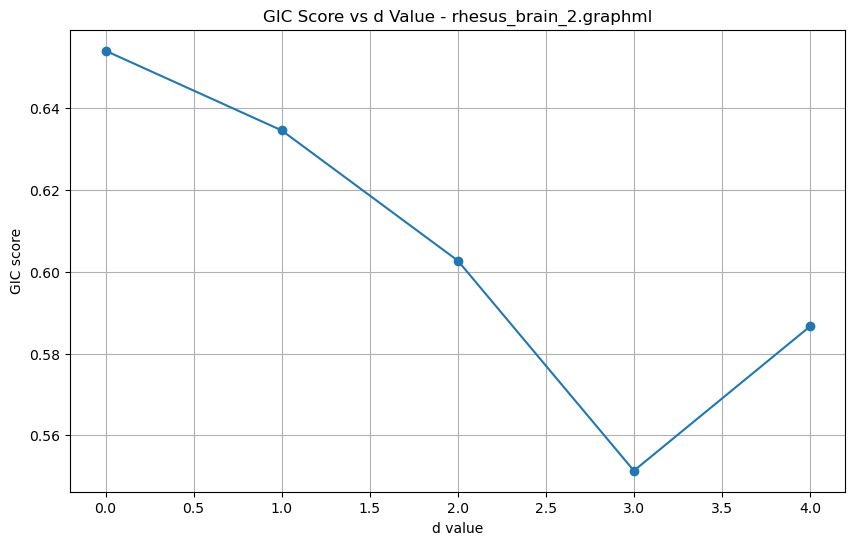

In [76]:
# Plot GIC vs d
plt.figure(figsize=(10, 6))
d_vals = []
gic_vals = []
for d, result in results.items():
    if 'gic' in result:  # Only plot if no error occurred
        d_vals.append(d)
        gic_vals.append(result['gic'])

plt.plot(d_vals, gic_vals, 'o-')
plt.xlabel('d value')
plt.ylabel('GIC score')
plt.title(f'GIC Score vs d Value - {connectome_file}')
plt.grid(True)
os.makedirs(f'../images/imgs_d_study/', exist_ok=True)
plt.savefig(f'../images/imgs_d_study/gic_vs_d_{connectome_file}.png', bbox_inches='tight')
plt.show()

In [77]:
11

11

## Analyse the final graph

In [28]:
warm_up = 6000
n_iteration = 6000
patience = 10

d = optimal_d
print(f'Optimal d: {d}')

Optimal d: 3


In [29]:
real_graph = nx.read_graphml(datasets + connectome_file)
logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
    real_graph=real_graph,
    d=d,
    warm_up=warm_up,
    n_iteration=n_iteration,
    patience=patience,
    dist_type='KL'
)
sim_graphs_dict = {
    'Real': real_graph,
    'Logit': nx.from_numpy_array(logit_graph)
}
result_dict = {
    'Real': {'GIC': 0},
    'Logit': {'GIC': gic_values[0]}
}

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.046      
Date:               2025-03-23 20:56 AIC:              19704.8677 
No. Observations:   36919            BIC:              19730.4171 
Df Model:           2                Log-Likelihood:   -9849.4    
Df Residuals:       36916            LL-Null:          -10320.    
Converged:          1.0000           LLR p-value:      4.7752e-205
No. Iterations:     18.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -4.2944     0.0960   -44.7555   0.0000   -4.4824   -4.1063
x1         0.0004     0.0000    25.3771   0.0000    0.0004    0.0005
x2         0.0002     0.0000     7.2816   0.0000    0.0001    0.0002

iteratio

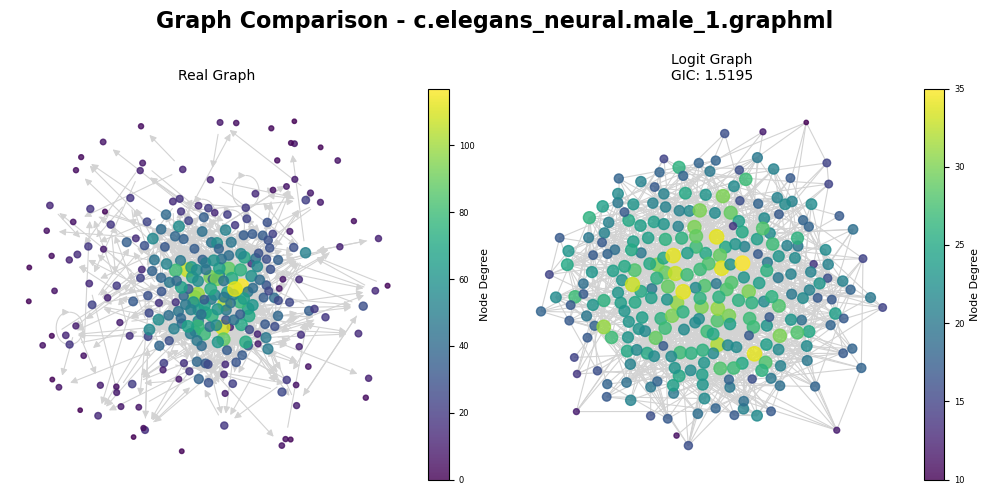

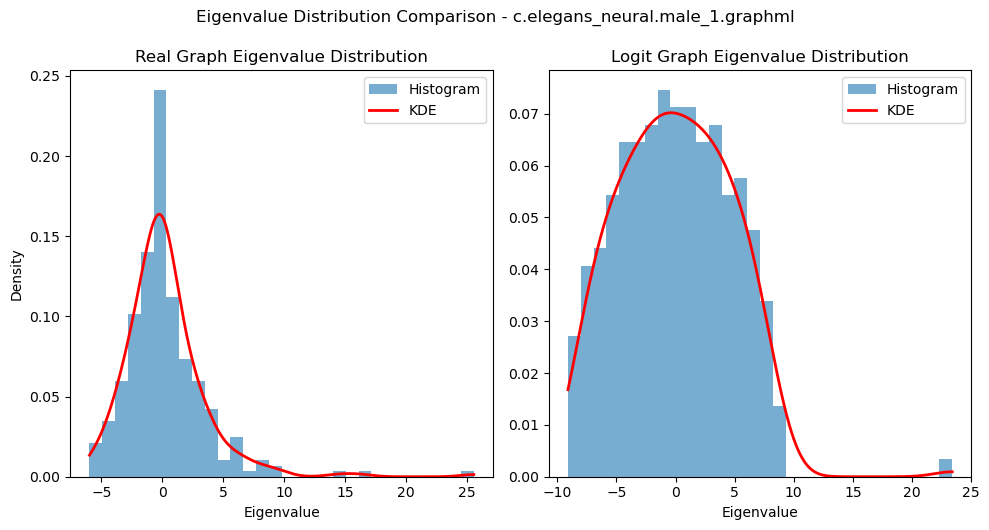

In [30]:
# Single connectome viz
fig = plot_graphs_in_matrix(
    sim_graphs_dict, 
    result_dict, 
    global_title=f'Graph Comparison - {connectome_file}',
    save_path=f'../images/imgs_connectomes_spectra_kde/graph_comparison_{connectome_file}.png'
)
plt.show()

# Compare eigenvalue distributions with KDE
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Get eigenvalues for both graphs
real_adj = nx.to_numpy_array(real_graph)
real_eigenvalues = np.linalg.eigvals(real_adj).real
real_eigenvalues = real_eigenvalues + np.random.normal(0, 1e-10, size=real_eigenvalues.shape)
logit_eigenvalues = np.linalg.eigvals(logit_graph).real
logit_eigenvalues = logit_eigenvalues + np.random.normal(0, 1e-10, size=logit_eigenvalues.shape)

# Plot for Real graph
axes[0].hist(real_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
real_kde = gaussian_kde(real_eigenvalues)
x_range = np.linspace(min(real_eigenvalues), max(real_eigenvalues), 1000)
axes[0].plot(x_range, real_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0].set_title('Real Graph Eigenvalue Distribution')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot for Logit graph
axes[1].hist(logit_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
logit_kde = gaussian_kde(logit_eigenvalues)
x_range = np.linspace(min(logit_eigenvalues), max(logit_eigenvalues), 1000)
axes[1].plot(x_range, logit_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[1].set_title('Logit Graph Eigenvalue Distribution')
axes[1].set_xlabel('Eigenvalue')
axes[1].legend()

plt.tight_layout()
plt.suptitle(f'Eigenvalue Distribution Comparison - {connectome_file}', y=1.05)
# plt.savefig(f'../images/imgs_connectomes_spectra_kde/eigenvalue_kde_{connectome_file}.png', bbox_inches='tight')
plt.show()

## Full plots

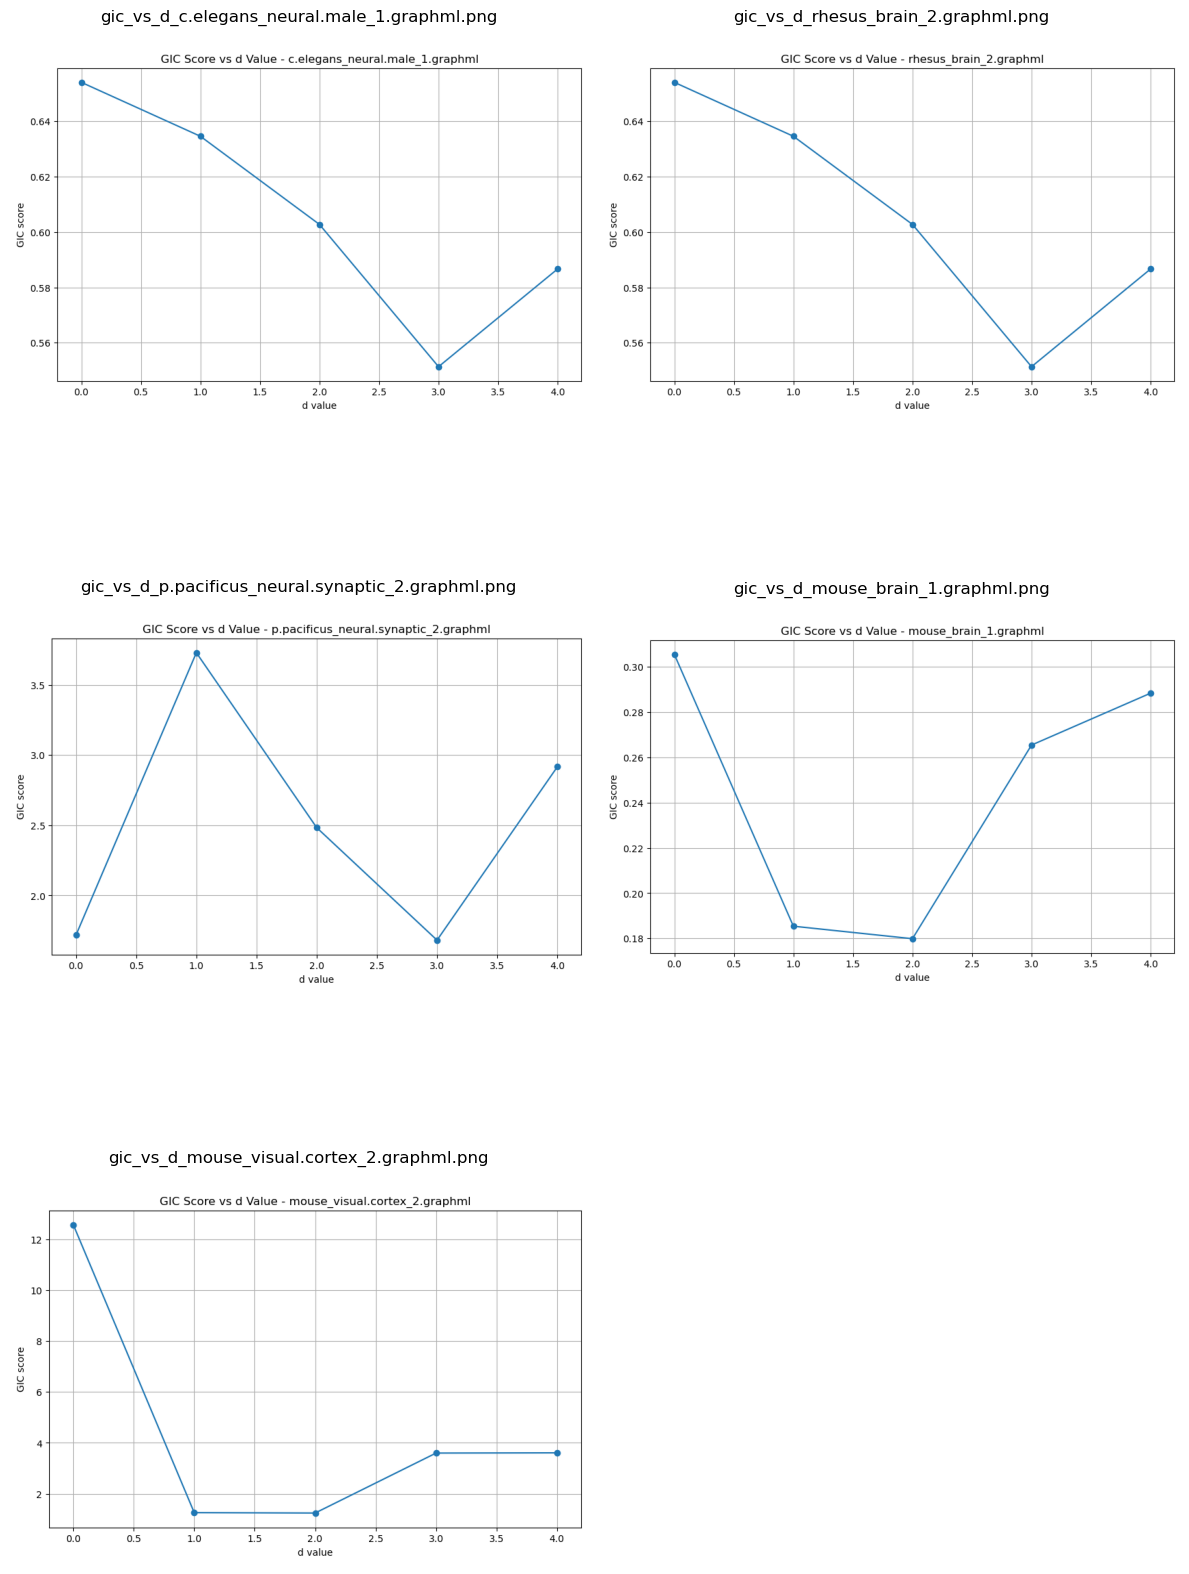

In [86]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

image_dir = '../images/imgs_d_study'
png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

n_images = len(png_files)
n_cols = 2
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

# Create figure
fig = plt.figure(figsize=(12, 6*n_rows))

# Add each image as a subplot
for i, png_file in enumerate(png_files, 1):
    img = imread(os.path.join(image_dir, png_file))
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(png_file, pad=20)

plt.tight_layout()
# Save figure
plt.savefig(f'../images/imgs_d_study/d_study_full.png', bbox_inches='tight')
plt.show()